# Example Notebook: Presidential party and the federal funds rate

This notebook shows how to turn a political economy question into a testable hypothesis, find data, and test it empirically.

### 1. Research Question:
Is the effective federal funds rate typically higher or lower when Republicans control the White House?

### 2. Testable hypothesis:
When the US has a Democratic president, the effective federal funds rate is lower than during Republican administrations

In [43]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Import additional packages (e.g., numpy) here if your transformations require them

### 3. Finding Data using FRED
We now pull the series you want to study plus a presidential party flag so we can compare regimes.

In [44]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='3a0ebd3c4baf668cb9f18d11334187fb')

# Choose the FRED series you want to analyze.
FRED_SERIES_ID = 'FEDFUNDS'  # Effective Federal Funds Rate
OBSERVATION_START = '1960-01-01'  # Adjust the time window as needed
OBSERVATION_END = '2025-12-01'

series_info = fred.get_series_info(FRED_SERIES_ID)
series_title = series_info.get('title', FRED_SERIES_ID) if hasattr(series_info, 'get') else FRED_SERIES_ID
series_units = series_info.get('units', '') if hasattr(series_info, 'get') else ''
analysis_label = f"{series_title} ({series_units})" if series_units else series_title

temp = fred.get_series(
    FRED_SERIES_ID,
    observation_start=OBSERVATION_START,
    observation_end=OBSERVATION_END,
)
df_series = (
    pd.DataFrame(data=temp, columns=['value'])
    .rename_axis('Date')
    .reset_index()
    .dropna()
)

df_series['Date'] = pd.to_datetime(df_series['Date']).dt.to_period('M').dt.to_timestamp()
df_series = df_series.sort_values('Date').reset_index(drop=True)

print(f"Loaded {FRED_SERIES_ID}: {analysis_label}")
print(df_series.head())
print(df_series.tail())

Loaded FEDFUNDS: Federal Funds Effective Rate (Percent)
        Date  value
0 1960-01-01   3.99
1 1960-02-01   3.97
2 1960-03-01   3.84
3 1960-04-01   3.92
4 1960-05-01   3.85
          Date  value
784 2025-05-01   4.33
785 2025-06-01   4.33
786 2025-07-01   4.33
787 2025-08-01   4.33
788 2025-09-01   4.22


In [45]:
# Transform the series for analysis (edit this cell to suit your project)
ANALYSIS_COLUMN = 'fed_funds_rate'  # Use your preferred column name

full_dates = pd.date_range('1960-01-01', '2025-12-01', freq='MS')
df_series = (
    df_series.set_index('Date')
    .reindex(full_dates)
    .rename_axis('Date')
    .reset_index()
)

df_series[ANALYSIS_COLUMN] = df_series['value']
# Example transformations you can try:
# df_series[ANALYSIS_COLUMN] = df_series['value'].diff()  # month-over-month change in percentage points
# df_series = df_series.dropna(subset=[ANALYSIS_COLUMN])

print(df_series[['Date', ANALYSIS_COLUMN]].head())
print(df_series[['Date', ANALYSIS_COLUMN]].tail())

        Date  fed_funds_rate
0 1960-01-01            3.99
1 1960-02-01            3.97
2 1960-03-01            3.84
3 1960-04-01            3.92
4 1960-05-01            3.85
          Date  fed_funds_rate
787 2025-08-01            4.33
788 2025-09-01            4.22
789 2025-10-01             NaN
790 2025-11-01             NaN
791 2025-12-01             NaN


In [46]:
# Build presidential party flags locally (no download needed)
from pandas.tseries.offsets import MonthBegin

terms = [
    ("1953-01-20", "1961-01-20", 1),  # Eisenhower (R)
    ("1961-01-20", "1963-11-22", 0),  # Kennedy (D)
    ("1963-11-22", "1969-01-20", 0),  # Johnson (D)
    ("1969-01-20", "1974-08-09", 1),  # Nixon (R)
    ("1974-08-09", "1977-01-20", 1),  # Ford (R)
    ("1977-01-20", "1981-01-20", 0),  # Carter (D)
    ("1981-01-20", "1989-01-20", 1),  # Reagan (R)
    ("1989-01-20", "1993-01-20", 1),  # George H. W. Bush (R)
    ("1993-01-20", "2001-01-20", 0),  # Clinton (D)
    ("2001-01-20", "2009-01-20", 1),  # George W. Bush (R)
    ("2009-01-20", "2017-01-20", 0),  # Obama (D)
    ("2017-01-20", "2021-01-20", 1),  # Trump (R)
    ("2021-01-20", "2025-12-31", 0),  # Biden (D) -- extend through 2025
]

full_dates = pd.date_range('1960-01-01', '2025-12-01', freq='MS')
df_gop = pd.DataFrame({'Date': full_dates})

def assign_party(ts):
    for start, end, gop_flag in terms:
        if pd.Timestamp(start) <= ts < pd.Timestamp(end):
            return gop_flag
    return 0

df_gop['GOP'] = df_gop['Date'].apply(assign_party)
df_gop['GOP'] = df_gop['GOP'].astype(int)

df_gop['Party'] = df_gop['GOP'].map({0: 'Democratic President', 1: 'Republican President'})

print(df_gop.head())
print(df_gop.tail())

        Date  GOP                 Party
0 1960-01-01    1  Republican President
1 1960-02-01    1  Republican President
2 1960-03-01    1  Republican President
3 1960-04-01    1  Republican President
4 1960-05-01    1  Republican President
          Date  GOP                 Party
787 2025-08-01    0  Democratic President
788 2025-09-01    0  Democratic President
789 2025-10-01    0  Democratic President
790 2025-11-01    0  Democratic President
791 2025-12-01    0  Democratic President


In [47]:
# Create new data frame that merges GOP flag with the selected FRED series
df = pd.merge(df_series, df_gop, on='Date', how='left')
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.tail())

        Date  value  fed_funds_rate  GOP                 Party
0 1960-01-01   3.99            3.99    1  Republican President
1 1960-02-01   3.97            3.97    1  Republican President
2 1960-03-01   3.84            3.84    1  Republican President
3 1960-04-01   3.92            3.92    1  Republican President
4 1960-05-01   3.85            3.85    1  Republican President
          Date  value  fed_funds_rate  GOP                 Party
787 2025-08-01   4.33            4.33    0  Democratic President
788 2025-09-01   4.22            4.22    0  Democratic President
789 2025-10-01    NaN             NaN    0  Democratic President
790 2025-11-01    NaN             NaN    0  Democratic President
791 2025-12-01    NaN             NaN    0  Democratic President


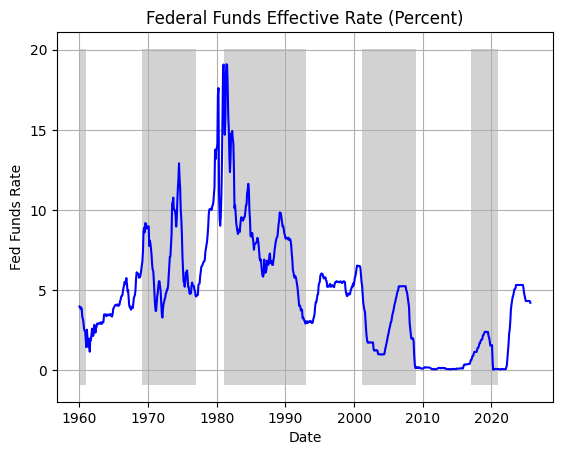

In [48]:
# Plot the indicator over time and shade GOP presidential terms
def plot_series(ax, data, index='Date', col=ANALYSIS_COLUMN, area='GOP', title=None, ylabel=None):
    plot_df = data[[index, col, area]].copy()
    plot_df[area] = plot_df[area].astype(int).astype(bool)
    ax.plot(plot_df[index], plot_df[col], color='blue')
    y1, y2 = ax.get_ylim()
    ax.fill_between(plot_df[index], y1, y2, where=plot_df[area], facecolor='grey', alpha=0.35)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel or col.replace('_', ' ').title())
    if title:
        ax.set_title(title)
    return ax

# set up figure, axis
f, ax = plt.subplots()
plot_series(ax, df, title=analysis_label)
ax.grid(True)
plt.show()


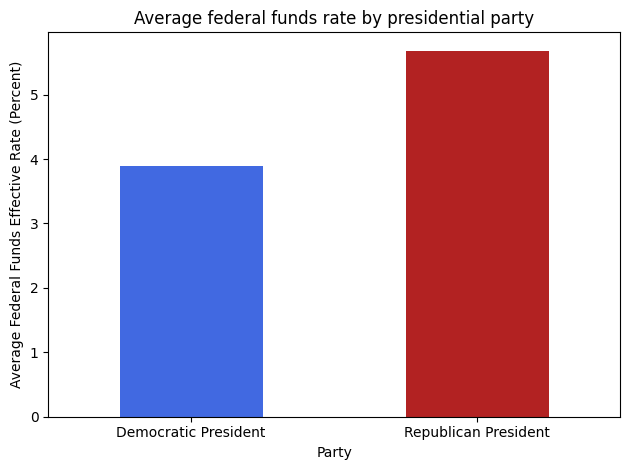

In [49]:
# Compare average values across parties
party_means = (
    df.groupby('Party')[ANALYSIS_COLUMN]
    .mean()
    .reindex(['Democratic President', 'Republican President'])
)

ax = party_means.plot(kind='bar', color=['royalblue', 'firebrick'], rot=0)
ax.set_ylabel(f'Average {analysis_label}')
ax.set_title('Average federal funds rate by presidential party')
plt.tight_layout()
plt.show()

### 4. Testing hypothesis empirically with OLS

In [50]:
# Run OLS regression of the indicator onto the GOP president flag
df['GOPlag'] = df['GOP'].shift()
reg_data = df.dropna(subset=['GOPlag', ANALYSIS_COLUMN]).copy()

X = sm.add_constant(reg_data['GOPlag'])
y = reg_data[ANALYSIS_COLUMN]
results = sm.OLS(y, X, missing='drop').fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         fed_funds_rate   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     44.53
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.72e-11
Time:                        14:23:37   Log-Likelihood:                -2110.7
No. Observations:                 788   AIC:                             4225.
Df Residuals:                     786   BIC:                             4235.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9491      0.171     23.056      0.0

### 5. Conclusion
From 1960–2025 the effective federal funds rate averaged about 3.95 % when Democrats occupied the White House and rose by roughly 1.68 percentage points under Republicans. The GOP coefficient is tightly estimated (p < 0.001), implying short-term policy rates were materially higher during Republican presidencies. Given the low R² and the clear role of macro conditions like inflation, further extensions should control for CPI or other economic indicators to gauge how much of the party gap reflects broader shocks rather than party-specific policy choices